# Introduction
This project is about creating an algorithm that would predict the detection of lung cancer based on CT scans. The algorithm would also predict what type of cancer is within the patient and the size of the tumor if applied.

In [32]:
# Import the necessary modules
# If you get a ModuleNotFoundError, use %pip install {module} to install the module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pandas as pd
from tcia_utils import nbia
import os
import sys
import itk
import pydicom as dicom
from pathlib import Path
import time
from zipfile import ZipFile 
import cv2
from tqdm import tqdm
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Data importing
In this chapter, the data will be imported. For this, I've selected a subset from the LUng-PET-CT-Dx collection from this link: https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70224216#7022421621c64ff049c44f03bb442ec5eb88bdf2


In [33]:
# Set start time
start_time = time.time()

# Get the data that's locally stored
basePath = Path("tciaDownload/manifest-1608669183333/Lung-PET-CT-Dx")

# Get the DICOM files present in the path set before
pathFiles = list(basePath.rglob('*.dcm'))

# Set the DICOM files in a numpy array
images = [dicom.filereader.dcmread(x) for x in pathFiles]
pixels = [image.pixel_array for image in images]
age = [image.PatientAge for image in images]
sex = [image.PatientSex for image in images]
patient_id = [image.PatientID for image in images]
cancer_type = [image.PatientID[8] for image in images]
sop_instance_uid = [image.SOPInstanceUID for image in images]

# Print time execution
print(f"Execution time: {time.time() - start_time} seconds")

Execution time: 131.68244862556458 seconds


In [34]:
# Put created lists into dataframe
# Set the has_cancer column manually to 1, since this contains data with patients that have the disease
colNames = ["patient_id", "sop_instance_id", "image_pixels", "patient_age", "patient_sex", "cancer_type", 'has_cancer']
data = [patient_id, sop_instance_uid, pixels, age, sex, cancer_type, 1]

df = pd.DataFrame()

for colName, values in tqdm(zip(colNames, data)):
    df[colName] = values

display(df.head())

7it [00:00, 32.95it/s]


,patient_id,sop_instance_id,image_pixels,patient_age,patient_sex,cancer_type,has_cancer
0,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.295499053390...,"[[44, 0, 10, 37, 0, 36, 70, 22, 0, 35, 0, 49, ...",053Y,F,A,1
1,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.314562946465...,"[[50, 0, 22, 26, 42, 25, 6, 51, 35, 7, 13, 33,...",053Y,F,A,1
2,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.142392682681...,"[[16, 3, 0, 89, 20, 10, 1, 22, 12, 61, 10, 25,...",053Y,F,A,1
3,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.117012811165...,"[[58, 0, 25, 71, 40, 48, 0, 0, 32, 49, 4, 46, ...",053Y,F,A,1
4,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.208988389922...,"[[13, 0, 27, 53, 18, 41, 26, 0, 37, 30, 68, 0,...",053Y,F,A,1


In [35]:
# Extract the normal lungs images from the zip file
normalLungs = "C:/Users/ardejong/Documents/final-project-elu/final-project-elu/normal_ct_scans.zip"
  

# open the zip file in read mode
with ZipFile(normalLungs, 'r') as normal_lungs_zip: 
    # Extract all the files
    normal_lungs_zip.extractall()

# Extract the PNG files
NormalLungFiles = glob.glob('C:/Users/ardejong/Documents/final-project-elu/final-project-elu/**/*.png', recursive=True)

normalLungsImages = []

# Read each PNG file in a for loop
for pathNormalLung in tqdm(NormalLungFiles):
    lungImage = cv2.imread(pathNormalLung, cv2.IMREAD_GRAYSCALE)
    lungImageResized = cv2.resize(lungImage, dsize = (512,512))
    normalLungsImages.append(lungImageResized)




100%|██████████| 203/203 [00:02<00:00, 93.33it/s] 


In [36]:
# Create dataframe based on PNG images and add has_cancer column with value of 0
df_normal_lungs = pd.DataFrame()
df_normal_lungs['image_pixels'] = normalLungsImages
df_normal_lungs["has_cancer"] = 0


# Add rows from other dataframe using the append function: pixel arrays and has_cancer 
sample_df_cancer = df.sample(n = df_normal_lungs.shape[0])
df_normal_lungs = pd.concat([df_normal_lungs, sample_df_cancer[['image_pixels', 'has_cancer']]], ignore_index= True)

# Reshape the image_pixels to one dimension
#df_normal_lungs['image_pixels'] = [x.flatten() for x in df_normal_lungs.image_pixels]

df_normal_lungs.head()

,image_pixels,has_cancer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [37]:
print(f"Shape of the DICOM dataset image: {df.image_pixels[0].shape}")
print(f"Shape of the PNG image: {df_normal_lungs.image_pixels[0].shape}")

Shape of the DICOM dataset image: (512, 512)
Shape of the PNG image: (512, 512)


In [38]:
df_normal_lungs.shape

(406, 2)

### Findings
The shapes of the images of both datasets are different. And to have a uniform size for the neural network that we'll build later, the iamges will be resized.

# Data cleaning
In this chapter, the data cleaning will be done. This involves mostly around feature engineering the structure of the images to make it ready for training the data.

## Setting the data types of the columns right

In [39]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       7700 non-null   object
 1   sop_instance_id  7700 non-null   object
 2   image_pixels     7700 non-null   object
 3   patient_age      7700 non-null   object
 4   patient_sex      7700 non-null   object
 5   cancer_type      7700 non-null   object
 6   has_cancer       7700 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 421.2+ KB
None


Based on the info method, the following columns needs to be changed:
- `patient_age`: to int
- `cancer_type`: to category
- `has_cancer`: to boolean

In [40]:
print(f"Lowest age: {min(df.patient_age)}")
print(f"Highest age: {max(df.patient_age)}")

Lowest age: 000Y
Highest age: 085Y


As you can see, the age column starts with a '0' and ends with a 'Y'. To clean this data, the 'Y' will be removed and the column data type will be converted to an integer.

In [41]:
# Clean up the patientAge column
df['patient_age'] = [int(x[0:-1]) for x in df.patient_age]

In [42]:
# Remap PatientSex and CancerType
cols = ['patient_sex', 'cancer_type']

dict_sex = {"M": "Male", "F": "Female"}
dict_cancer_type = {'A': "Adenocarcinoma", 'B': "Small Cell Carcinoma", 'E': "Large Cell Carcinoma", "G": "Squamous Cell Carcinoma"}

df = df.replace({cols[0]: dict_sex, cols[1]: dict_cancer_type})

# Turn PatientSex and CancerType into categorical columns
df[cols] = df[cols].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   patient_id       7700 non-null   object  
 1   sop_instance_id  7700 non-null   object  
 2   image_pixels     7700 non-null   object  
 3   patient_age      7700 non-null   int64   
 4   patient_sex      7700 non-null   category
 5   cancer_type      7700 non-null   category
 6   has_cancer       7700 non-null   int64   
dtypes: category(2), int64(2), object(3)
memory usage: 316.3+ KB


In [43]:
df.head()

,patient_id,sop_instance_id,image_pixels,patient_age,patient_sex,cancer_type,has_cancer
0,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.295499053390...,"[[44, 0, 10, 37, 0, 36, 70, 22, 0, 35, 0, 49, ...",53,Female,Adenocarcinoma,1
1,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.314562946465...,"[[50, 0, 22, 26, 42, 25, 6, 51, 35, 7, 13, 33,...",53,Female,Adenocarcinoma,1
2,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.142392682681...,"[[16, 3, 0, 89, 20, 10, 1, 22, 12, 61, 10, 25,...",53,Female,Adenocarcinoma,1
3,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.117012811165...,"[[58, 0, 25, 71, 40, 48, 0, 0, 32, 49, 4, 46, ...",53,Female,Adenocarcinoma,1
4,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.208988389922...,"[[13, 0, 27, 53, 18, 41, 26, 0, 37, 30, 68, 0,...",53,Female,Adenocarcinoma,1


## Normalizing the data
In this paragraph, the data will be normalized. For the binary classificatino model, this will go for the image pixels

In [44]:
# Normalize the data for the binary classification dataframe
#df_normal_lungs['image_pixels'] = df_normal_lungs.image_pixels / 255

df_normal_lungs.head()

,image_pixels,has_cancer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


# Data visualization
In this chapter, some visualizations will be done to get more insight into the data.

In [45]:
# Create function that shows the distribution between a set of columns
def distributionPlot(x, colors, labels, title):
    x = x.value_counts(normalize = True)

    plt.pie(x = x, colors = colors, labels = x.index, autopct = "%0.3f%%", startangle = 90)
    plt.title(title)
    plt.show()

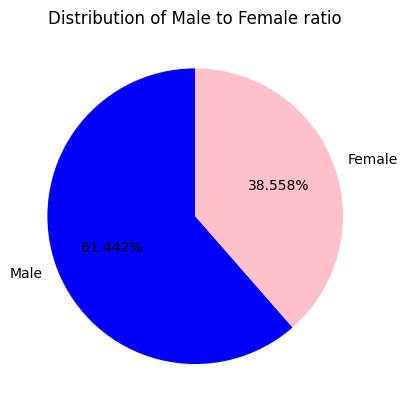

In [46]:
# Check the distirbution of Male to Female patients
# Set up parameters
colors = ['blue', 'pink']
labels = ["Male", "Female"]
title = "Distribution of Male to Female ratio"

distributionPlot(df.patient_sex, colors, labels, title)

In [47]:
a = 262144
print(a % 2)

0


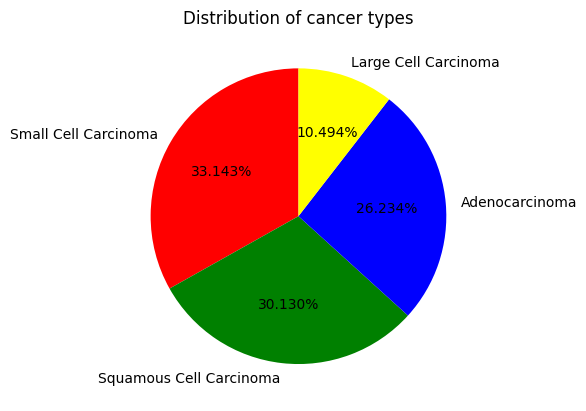

In [48]:
types = ['Adenocarcinoma', 'Small Cell Carcinoma']

# Check the distribution of cancer Types
# Set up parameters
colors = ['Red', 'Green', 'Blue', 'Yellow']
title = "Distribution of cancer types"

# Call distributionPlot function to show distribution
distributionPlot(df.cancer_type, colors, labels, title)

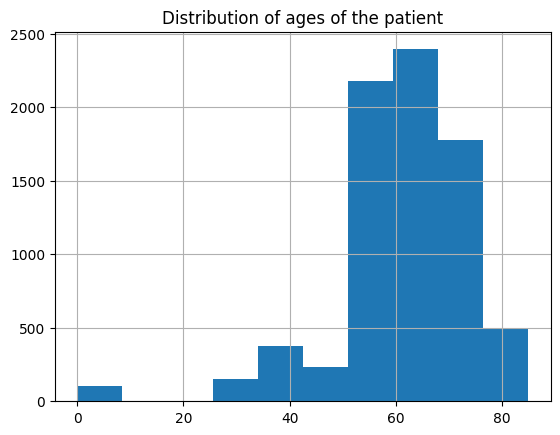

In [49]:
# check the distribution of ages of the pages
df.patient_age.hist()
plt.title("Distribution of ages of the patient")
plt.show()

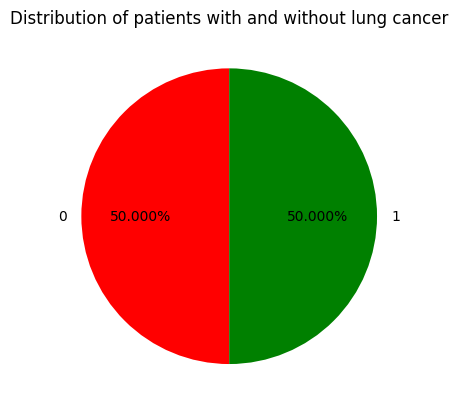

In [50]:
# Show distribution of cancer vs non-cancer patients
# Set parameters
title = "Distribution of patients with and without lung cancer"
colors = ["red", 'green']

# Call distributionPlot function to show distribution
distributionPlot(df_normal_lungs.has_cancer, colors, labels, title)

In [51]:
# visualize a few images and tell more about it.

# Model building, training and testing
In this chapter, the model will be build and trained before it will be tested among the test data.


In [56]:
# Split the data for the binary classification using train_test_split
x = np.array([np.array(val) for val in df_normal_lungs.image_pixels])
y = df_normal_lungs.has_cancer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [59]:
# reshape dataset to have a single channel
#X_train = np.array([np.array(val) for val in X_train])
train_tf = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_tf = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [72]:
train_tf

<TensorSliceDataset element_spec=(TensorSpec(shape=(512, 512), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [74]:
# Craete neural network with binary output
model_binary = tf.keras.models.Sequential([
                                    #tf.keras.layers.Conv2D(12, (3,3), activation='relu', input_shape=(512,512)),
                                    tf.keras.layers.Flatten(input_shape = (512, 512)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    #tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])


# Compile the model 
model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])      

# Train the model
model_binary.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 15, batch_size = 32)

Epoch 1/15
11/11 [==============================] - 3s 149ms/step - loss: 16693.3320 - accuracy: 0.7377 - val_loss: 686.2515 - val_accuracy: 0.9634
Epoch 2/15
11/11 [==============================] - 1s 83ms/step - loss: 1832.7620 - accuracy: 0.9321 - val_loss: 680.7003 - val_accuracy: 0.9634
Epoch 3/15
11/11 [==============================] - 1s 87ms/step - loss: 903.4596 - accuracy: 0.9599 - val_loss: 135.9957 - val_accuracy: 0.9756
Epoch 4/15
11/11 [==============================] - 1s 78ms/step - loss: 559.3163 - accuracy: 0.9753 - val_loss: 119.5509 - val_accuracy: 0.9878
Epoch 5/15
11/11 [==============================] - 1s 78ms/step - loss: 295.6243 - accuracy: 0.9815 - val_loss: 403.2528 - val_accuracy: 0.9878
Epoch 6/15
11/11 [==============================] - 1s 78ms/step - loss: 559.6124 - accuracy: 0.9877 - val_loss: 36.4609 - val_accuracy: 0.9878
Epoch 7/15
11/11 [==============================] - 1s 94ms/step - loss: 767.9689 - accuracy: 0.9568 - val_loss: 14.2891 - val_

# Results
In this chapter, the results will be shown. For this, we'll look into the following:
- The True Negative Rate for detecting the lung cancer
- The Mean Absolute Error (MAE) for the size of the tumor
- Accuracy for the type of cancer and the corresponding confidence score.